In [ ]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import  mean_squared_error

import dateutil.easter as easter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Objective

For this challenge, you will be predicting a full year worth of sales for three items at two stores located in three different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. The dataset is small enough to allow you to try numerous different modeling approaches

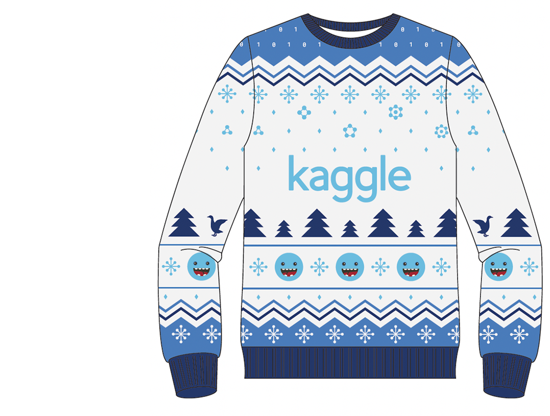

- Files
    * train.csv - the training set, which includes the sales data for each date-country-store-item combination.
    * test.csv - the test set; your task is to predict the corresponding item sales for each date-country-store-item combination. Note the Public leaderboard is scored on the first quarter of the test year, and the Private on the remaining.
    * sample_submission.csv - a sample submission file in the correct format

In [ ]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/test.csv')
sub = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv')

holiday = pd.read_csv('../input/holidays-finland-norway-sweden-20152019/Holidays_Finland_Norway_Sweden_2015-2019.csv')
gdp = pd.read_csv('../input/tps-jan-2022-gdp-data-long-format/gdp_long.csv')

print(train.shape)
print(test.shape)
print(sub.shape)
print(holiday.shape)
print(gdp.shape)

In [ ]:
gdp

In [ ]:
df = pd.concat([train, test]).fillna(0)

df['type'] = df['country'].astype(str) + '_' + df['store'].astype(str) + '_' + df['product'].astype(str)
df['date'] = pd.to_datetime(df['date'])
df.head()

In [ ]:
import random
smp = random.sample(df['type'].unique().tolist(), 3)
print(smp, '\n')

plt.figure(figsize = (15,6))
for s in smp:
    
    plt.plot(df[df.type == s]['date'], df[df.type == s]['num_sold'], label = s)
    plt.legend()
    plt.xticks(rotation = 45)


# Feature Engineering

In [ ]:
holiday['Date'] = pd.to_datetime(holiday['Date'])
holiday

In [ ]:
# Date Features
df['dow'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['week']= df['date'].dt.week
df['year'] = df['date'].dt.year

dayofyear = df.date.dt.dayofyear

# Seasonality features
for k in range(1, 20):
    df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
    df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
   
     
# Merge with holiday
df = df.merge(holiday, how = 'left', left_on = ['country','date'], right_on = ['Country','Date']).drop(['Country','Date','LocalName','Fixed'], axis = 1).fillna('NA')

# Merge with GDP
df = df.merge(gdp, on = ['year','country'], how = 'left')


### More advanced features

In [ ]:
# Easter
easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
df['days_from_easter'] = (df.date - easter_date).dt.days.clip(-3, 59)
df.loc[df['days_from_easter'].isin(range(12, 39)), 'days_from_easter'] = 12 # reduce overfitting
#new_df.loc[new_df['days_from_easter'] == 59, 'days_from_easter'] = -3

# Last Wednesday of June
wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                     2016: pd.Timestamp(('2016-06-29')),
                                     2017: pd.Timestamp(('2017-06-28')),
                                     2018: pd.Timestamp(('2018-06-27')),
                                     2019: pd.Timestamp(('2019-06-26'))})
df['days_from_wed_jun'] = (df.date - wed_june_date).dt.days.clip(-5, 5)

# First Sunday of November (second Sunday is Father's Day)
sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                     2016: pd.Timestamp(('2016-11-6')),
                                     2017: pd.Timestamp(('2017-11-5')),
                                     2018: pd.Timestamp(('2018-11-4')),
                                     2019: pd.Timestamp(('2019-11-3'))})
df['days_from_sun_nov'] = (df.date - sun_nov_date).dt.days.clip(-1, 9)

df.head()

# Pre-processing

In [ ]:
le = LabelEncoder()
cat_cols = ['country','store','product','type','Name']

for c in cat_cols:
    df[c] = le.fit_transform(df[c])

In [ ]:
def smape(pred, obs):
    pred = np.array(pred)
    obs = np.array(obs)   
    return 100 * np.mean(2 * abs(pred-obs)/(abs(obs)+abs(pred)))

# XGB Modeling

In [ ]:
train = df[:len(train)]
test = df[-len(test):]
print(train.shape)
print(test.shape)

X_train = train.drop(['row_id','date','num_sold','gdp'], axis = 1)
y_train = np.log(train['num_sold'] / train['gdp'])
X_test = test.drop(['row_id','date','num_sold','gdp'], axis = 1)

cols = list( X_train.columns )

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

In [ ]:
# Calculating edges of target bins to be used for stratified split
target_bin_edges = np.histogram_bin_edges(train["num_sold"], bins=5)
print(target_bin_edges)
target_bin_edges[0] = -np.inf
target_bin_edges[-1] = np.inf
target_bins = pd.cut(train["num_sold"], target_bin_edges, labels=np.arange(5))
target_bins.value_counts()

In [ ]:
print("XGBoost version:", xgb.__version__)

## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

In [ ]:
oof_pred = True

if oof_pred:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = StratifiedKFold(n_splits =  5, shuffle = True, random_state = 2022)

    for i, (idxT, idxV) in enumerate( skf.split(X_train, target_bins) ):
        print('Fold:', i+1)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBRegressor(
            n_estimators = 1000,
    max_depth = 7,
    learning_rate = 0.03,
    subsample = 0.8,
    colsample_bytree = 0.8,
    missing = -1,
            reg_alpha =  1,
    
        )        
        h = clf.fit(X_train.loc[idxT], y_train.loc[idxT], eval_metric = 'mae',
                eval_set=[(X_train.loc[idxT], y_train.loc[idxT]),(X_train.loc[idxV],y_train.loc[idxV])],
                verbose=200, early_stopping_rounds=50)
    
        oof[idxV] += np.exp(clf.predict(X_train.iloc[idxV])) * (train['gdp'].iloc[idxV])
        preds += np.exp(clf.predict(X_test)) * test['gdp']/skf.n_splits
      
    print('#'*20)
    print ('XGB OOF CV RMSE =', mean_squared_error(train['num_sold'],oof)**0.5)
    print ('XGB OOF CV SMAPE =', smape(train['num_sold'],oof))

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(oof,bins=100)
plt.title('XGB OOF')
plt.show()

In [ ]:
sub.num_sold = preds.values
sub.to_csv('sub_xgb.csv',index=False)

plt.hist(sub.num_sold, bins=100)
plt.title('XGB Submission')
plt.show()

In [ ]:
sub